In [1]:
!pip install import-ipynb


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install seaborn hf_xet torch torchvision transformers tqdm requests datasets accelerate bitsandbytes tensorboard torch-tb-profiler openai anthropic google-generativeai


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# --- core python libs ---
import os, json, pickle, random, math, itertools
from collections import defaultdict, Counter

# --- scientific stack ---
import torch, numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt;  plt.style.use("ggplot")
import seaborn as sns

# --- hugging-face & datasets ---
from datasets import load_dataset
from transformers import AutoTokenizer

# --- your ENN components ---
#  (if they live in another notebook / .py file, adjust the import path)
import import_ipynb                     # enables ipynb imports
from enn_helpers import LlamaBaseNet, EpiNet, PriorNet, EpistemicNN, sample_z

z_dim = 16

/Users/jaytipirneni/.pyenv/versions/3.11.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Using device: mps
Torch: 2.7.0   Free RAM: 7.491076096 GB
MPS cap: True
macOS-13.4-arm64-arm-64bit 2.7.0
MPS available: True
Loading HaluEval dataset from Hugging Face...
Loading qa dataset...
Loading dialogue dataset...
Loading summarization dataset...
Loading general dataset...
Merging all training data...
Merging all test data...
HaluEval dataset preparation complete!
Train data: data/halueval/train.jsonl
Test data: data/halueval/test.jsonl


In [4]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
print("evaluating on", device)

evaluating on mps


In [5]:
enn_ckpt_path = "enn_halueval_model.pt"           # your saved ENN
base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" # the base encoder used in training
num_classes     = 2                               # factual vs hallucination
max_length      = 128                             # token length for ENN


ensemble_models = [
    "gpt-4o",
    "gpt-4.1-2025-04-14",
    "claude-sonnet-4-20250514",
    "claude-opus-4-20250514"
]

rng = random.Random(42)

In [6]:
def load_enn(ckpt:str):
    """Re-build the architecture exactly as in training, then load weights."""
    # base encoder the ENN wraps
    base   = LlamaBaseNet(base_model_name, num_classes).to(device)
    feat_d = base.hidden_size

    # same latent/hyper-params you used when training
    z_dim, hidden_dims = 16, [128, 64]
    epinet = EpiNet(feat_d, z_dim, hidden_dims, num_classes).to(device)
    prior  = PriorNet(feat_d, z_dim, num_classes).to(device)

    enn = EpistemicNN(base, epinet, prior).to(device)
    state = torch.load(ckpt, map_location=device)
    enn.load_state_dict(state)
    enn.eval()

    return enn, base.tokenizer

enn, tokenizer = load_enn(enn_ckpt_path)
print("✔ ENN loaded.")

✔ ENN loaded.


In [7]:
@torch.inference_mode()
def enn_uncertainty(question: str,
                    answer:   str,
                    z_dim:    int,
                    num_samples: int = 8) -> float:
    """
    Run the ENN `num_samples` times with different epistemic indices z.
    Return the summed variance of the logits (scalar uncertainty).
    """
    text = f"User query: {question}\nAnswer: {answer}"
    ids  = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    ).input_ids.to(device)

    logits_samples = []
    for _ in range(num_samples):
        z = sample_z(1, z_dim, device)          # ← draw an epistemic index
        logits = enn(ids, z)                    # forward pass
        logits_samples.append(logits.squeeze(0))  # [num_classes]

    stack = torch.stack(logits_samples)          # [S, num_classes]
    return stack.var(0).sum().item()             # scalar

In [10]:
import time, httpx
import openai, anthropic, google.generativeai as genai

openai_client     = openai.Client()
anthropic_client  = anthropic.Anthropic()
genai.configure()                                   # Google

def _retry_loop(fn, max_tries=4, delay=2.0):
    for attempt in range(max_tries):
        try:
            return fn()
        except (openai.OpenAIError,
                anthropic.APIStatusError,
                httpx.TimeoutException,
                TimeoutError) as e:
            if attempt == max_tries - 1:
                raise
            wait = delay * (2 ** attempt)
            print(f"⚠️  {e.__class__.__name__}: retrying in {wait:.1f}s …")
            time.sleep(wait)

def call_model(model_name: str,
               prompt: str,
               timeout_s: float = 60.0,
               max_tries: int  = 4) -> str:

    def _openai():
        resp = openai_client.chat.completions.create(
            model=model_name,                      # ← single ‘model=’
            messages=[{"role": "user", "content": prompt}],
            temperature=0.5,
            timeout=timeout_s
        )
        return resp.choices[0].message.content.strip()

    def _anthropic():
        resp = anthropic_client.messages.create(
            model=model_name,
            max_tokens=1024,
            temperature=0.5,
            messages=[{"role": "user", "content": prompt}],
            timeout=timeout_s
        )
        return resp.content[0].text.strip()

    def _gemini():
        model = genai.GenerativeModel(model_name)
        with httpx.Client(timeout=timeout_s):
            resp = model.generate_content(
                prompt,
                generation_config={"temperature": 0.5}
            )
        return resp.text.strip()

    if model_name.startswith("gpt"):
        return _retry_loop(_openai,   max_tries)
    elif model_name.startswith("claude"):
        return _retry_loop(_anthropic, max_tries)
    elif model_name.startswith("gemini"):
        return _retry_loop(_gemini,    max_tries)
    else:
        raise ValueError(f"unknown model → {model_name}")

In [11]:
CACHE_F = "truthful_qa_cache.pkl"
cache = pickle.load(open(CACHE_F, "rb")) if os.path.exists(CACHE_F) else {}

def cached_call(model:str, prompt:str) -> str:
    key = (model, prompt)
    if key not in cache:
        cache[key] = call_model(model, prompt)
    return cache[key]

In [12]:
truthful = load_dataset("truthful_qa", "generation", split="validation")
print(f"{len(truthful)} questions loaded.")

817 questions loaded.


In [ ]:
records         = []                   # full logs
selection_count = Counter()            # how often ENN picks each model

for row in tqdm(truthful, total=len(truthful)):
    q = row["question"]

    # 1. generate answers from every model in the ensemble
    answers, uncertainties = {}, {}
    for m in ensemble_models:
        ans                      = cached_call(m, q)
        answers[m]               = ans
        uncertainties[m]         = enn_uncertainty(q, ans, z_dim)

    # 2. ENN chooses the most certain answer
    best_model = min(uncertainties, key=uncertainties.get)
    selection_count[best_model] += 1

    records.append(
        {
            "question"     : q,
            "ground_truth" : row["best_answer"],
            "winner_model" : best_model,
            "winner_answer": answers[best_model],
            "winner_unc"   : uncertainties[best_model],
            **{f"{m}_unc":u for m,u in uncertainties.items()}
        }
    )

# persist the API-call cache for potential resume
with open(CACHE_F, "wb") as f:  pickle.dump(cache, f)

results_df = pd.DataFrame(records)
print("✓ evaluation finished")

  2%|▏         | 13/817 [07:24<6:15:16, 28.01s/it]

In [12]:
def em(pred, gold):   # case- & space-insensitive
    return pred.strip().lower() == gold.strip().lower()

results_df["correct"] = results_df.apply(
    lambda r: em(r.winner_answer, r.ground_truth), axis=1
)
overall_acc = results_df.correct.mean()
print(f"\nOverall EM accuracy of ENN-selected answers: {overall_acc:.3%}")


Overall EM accuracy of ENN-selected answers: 0.000%


/var/folders/gl/09jc9_ws3n32w206sfy45nxm0000gn/T/ipykernel_25706/1424506449.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


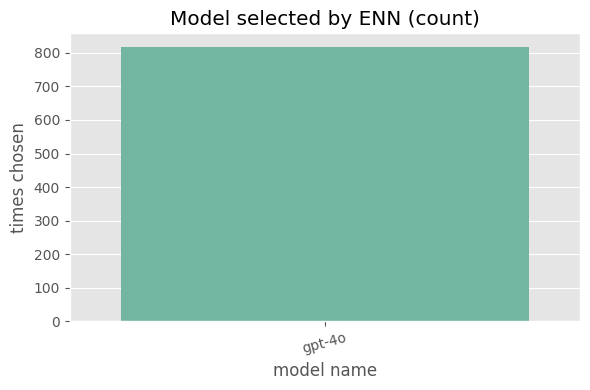

/var/folders/gl/09jc9_ws3n32w206sfy45nxm0000gn/T/ipykernel_25706/1424506449.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=melted, x="model", y="uncertainty", palette="pastel")


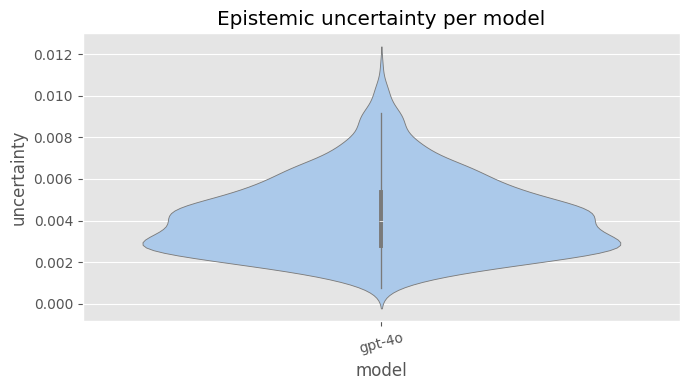

/var/folders/gl/09jc9_ws3n32w206sfy45nxm0000gn/T/ipykernel_25706/1424506449.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_by_model, x="winner_model", y="correct", palette="Set3")


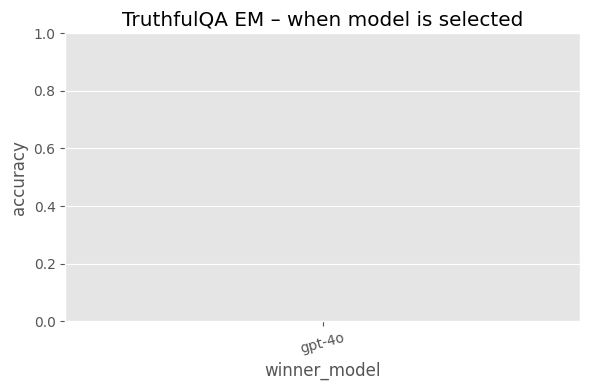

In [13]:
# --- 1)  selection frequency barplot -------------------
plt.figure(figsize=(6,4))
sns.barplot(
    x=list(selection_count.keys()),
    y=list(selection_count.values()),
    palette="Set2"
)
plt.title("Model selected by ENN (count)")
plt.ylabel("times chosen");  plt.xlabel("model name");  plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- 2)  uncertainty distribution violin ---------------
melted = (
    results_df
      .melt(
          id_vars=["question"], 
          value_vars=[f"{m}_unc" for m in ensemble_models],
          var_name="model", value_name="uncertainty"
      )
      .assign(model=lambda d: d.model.str.replace("_unc",""))
)

plt.figure(figsize=(7,4))
sns.violinplot(data=melted, x="model", y="uncertainty", palette="pastel")
plt.title("Epistemic uncertainty per model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- 3)  accuracy broken down by chosen model ----------
acc_by_model = (
    results_df.groupby("winner_model")["correct"].mean().reset_index()
)
plt.figure(figsize=(6,4))
sns.barplot(data=acc_by_model, x="winner_model", y="correct", palette="Set3")
plt.title("TruthfulQA EM – when model is selected")
plt.ylabel("accuracy"); plt.ylim(0,1); plt.xticks(rotation=15)
plt.tight_layout()
plt.show()